In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
pd.options.mode.chained_assignment = None  # default='warn'

from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
# import matplotlib.dates as mdates # Styling dates
# import mplfinance as mpf # Matplotlib finance
from datetime import timedelta

# Get the data
df_basic = pd.read_csv('./cleaned/real/basic.csv')
df_other = pd.read_csv('./cleaned/real/other.csv')
df_dividend = pd.read_csv('./cleaned/real/dividend.csv')

df_basic = pd.read_csv('./cleaned/synthetic/basic.csv')
df_other = pd.read_csv('./cleaned/synthetic/other.csv')
df_dividend = pd.read_csv('./cleaned/synthetic/dividend.csv')

In [2]:
# Format date fields
df_basic['Date'] = pd.to_datetime(df_basic['Date'])
df_other['Date'] = pd.to_datetime(df_other['Date'])
df_dividend['Date'] = pd.to_datetime(df_dividend['Date'])

In [3]:
# Account for stock splits

tickers_all = df_basic['Name'].unique()
allSplits = []

for ticker in tickers_all:

    # Get the split and convert to a df
    splits = yf.Ticker(ticker).splits

    df_split = []

    # If there was a split, append the df to allSplits. The ignoring of PFE is a quirk with a spin off they did with Viatris in 2020. This is a bad fix but it'll do for now
    if len(splits) != 0 and ticker != "PFE" and ticker != "INRG.L":
        df_split = pd.DataFrame({'Date':splits.index, 'Split':splits.values})
        df_split["Name"] = ticker
        allSplits.append(df_split)

allSplits = pd.concat(allSplits)

# Iterate through splits and alter share counts as necessary
for index, row in allSplits.iterrows():
    df_basic.loc[(df_basic["Name"] == row["Name"]) & (df_basic["Date"] < row["Date"]), ["ShareCount"]] = (df_basic['ShareCount'] * row["Split"]).round(6)

In [4]:
# Get a valid pandas date
def getDateFormat(day, month, year):
    return pd.to_datetime(f"{year}-{month}-{day}")

In [5]:
# Get the shares held on a given day
def getDayPortfolio(day = pd.to_datetime("today")):

    # Get the buys and sells for each day before the given date
    df_buysInRange = df_buys.loc[df_basic["Date"] <= day, ["Date", "Name", "ShareCount"]]
    df_sellsInRange = df_sells.loc[df_basic["Date"] <= day, ["Date", "Name", "ShareCount"]]

    # Any missing sells, i.e. any stock we've bought but not sold any of, need to still be in the resulting 'sell' df
    df_emptySells = df_buysInRange.copy()
    df_emptySells["ShareCount"] = 0
    df_sellsInRange = pd.concat([df_sellsInRange, df_emptySells])

    # Aggregate to get total shares in and out
    sharesIn = df_buysInRange.groupby('Name').agg({'ShareCount': 'sum'})['ShareCount'].reset_index()
    sharesOut = df_sellsInRange.groupby('Name').agg({'ShareCount': 'sum'})['ShareCount'].reset_index()

    # Format the aggregations
    sharesIn.rename(columns={"ShareCount": "SharesIn"}, inplace=True)
    sharesOut.rename(columns={"ShareCount": "SharesOut"}, inplace=True)
    sharesOut.drop(columns="Name", inplace=True)

    # Calculate net shares
    sharesTotal = pd.concat([sharesIn, sharesOut], axis=1)
    sharesTotal["ShareCount"] = (sharesTotal["SharesIn"] - sharesTotal["SharesOut"]).round(5)

    # Format the portfolio
    portfolio = sharesTotal.loc[sharesTotal["ShareCount"] != 0]
    portfolio = portfolio.drop(columns=["SharesIn", "SharesOut"])

    return portfolio

In [6]:
#Split buys and sells into separate dataframes
df_buys = df_basic.loc[df_basic["Type"] == "BUY"]
df_sells = df_basic.loc[df_basic["Type"] == "SELL"]

# A list of currently held tickers
tickers_current = getDayPortfolio()["Name"].explode().unique() 

# A list of all tickers with their currency
tickers_currency = df_buys[["Name", "Currency"]].drop_duplicates().reset_index(drop=True)

In [7]:
# Get any necessary exchange rates
df_exchange_USDGBP = web.DataReader("GBPUSD=X", 'yahoo', df_buys["Date"].min(), pd.to_datetime("today"))
df_exchange_USDGBP.drop(columns=["High", "Low", "Open", "Volume", "Adj Close"], inplace=True)
df_exchange_USDGBP = df_exchange_USDGBP.reset_index()

# Get the first and last date
currentDate_fx = df_exchange_USDGBP["Date"].min()
lastDate_fx = pd.to_datetime("today")
lastDate_fx = lastDate_fx.replace(hour=0, minute=0, second=0, microsecond=0)

# Iterate through each day
while currentDate_fx != lastDate_fx:
    dayCounter_fx = 1

    # If the current day doesn't have an exchnage rate entry
    while len(df_exchange_USDGBP.loc[df_exchange_USDGBP["Date"] == currentDate_fx]) == 0:

        # Get the previous days entry
        prevDate_fx = currentDate_fx - timedelta(days=dayCounter_fx)
        df_previousFx = df_exchange_USDGBP.loc[df_exchange_USDGBP["Date"] == prevDate_fx]
        df_previousFx["Date"] = currentDate_fx

        # Add this entry to the exchange rate df
        df_exchange_USDGBP = df_exchange_USDGBP.append(df_previousFx, ignore_index=True)
        dayCounter_fx += 1

    currentDate_fx = currentDate_fx + timedelta(days=1)

# Rename the Close column to avoid confusion in the next cell...
df_exchange_USDGBP = df_exchange_USDGBP.rename(columns={"Close": "Rate"})


In [11]:
# Import all closing prices for each ticker for the required date ranges
df_closing_all = []

for ticker in tickers_all:

    df_closing_ticker = []

    # Get the first transaction date for the ticker
    date_first = pd.to_datetime("today")
    date_first = df_buys.loc[df_buys["Name"] == ticker]["Date"].min()

    # Get the last transaction date for the ticker, or the current date if it's still being held
    date_last = pd.to_datetime("today")
    if ticker not in tickers_current:
        date_last = df_sells.loc[df_sells["Name"] == ticker]["Date"].max()

    # Get the close prices for each day
    # Yahoo has missing data for INRG. This isn't ideal but it's the best way to fix it - will need to manually download any mising data in future
    if ticker == "INRG.L":
        df_closing_ticker = pd.read_csv('./inputs/inrg.csv')
        df_closing_ticker["Date"] = pd.to_datetime(df_closing_ticker["Date"])
    else:
        df_closing_ticker = web.DataReader(ticker, 'yahoo', date_first, date_last)    

    dayCounter = 1
    
    while (date_first - df_closing_ticker.index.min())/np.timedelta64(1, 'D') < 0:
        df_closing_ticker = web.DataReader(ticker, 'yahoo', date_first - timedelta(days=dayCounter), date_last)  
        dayCounter += 1 

    # Format the df
    df_closing_ticker.drop(columns=["High", "Low", "Open", "Volume", "Adj Close"], errors="ignore", inplace=True)
    df_closing_ticker["Name"] = ticker

    # Get the currency for the current ticker
    tickerCurrency = tickers_currency.loc[tickers_currency["Name"] == ticker, "Currency"].values[0]

    # If it's USD, divide by the exchange rate for the relevant day
    if tickerCurrency == "USD":
        df_closing_ticker = pd.merge(df_closing_ticker, df_exchange_USDGBP, how="left", on="Date")
        df_closing_ticker["Close"] = df_closing_ticker["Close"]/df_closing_ticker["Rate"]
        df_closing_ticker.drop(columns=["Rate"], inplace=True)

    # If it's GBp, divide by 100 to convert to £
    elif tickerCurrency == "GBP":
        df_closing_ticker["Close"] = df_closing_ticker["Close"]/100
    else:
        print("ERROR: Unidentified Currency - ", ticker)
    
    df_closing_all.append(df_closing_ticker.reset_index())

# Concatenate all data
df_closing_all = pd.concat(df_closing_all)
df_closing_all.drop(columns=["index"], inplace=True)


In [12]:
# Get daily portfolio value
dates = []
values = []

currentDate = df_buys["Date"].min()

endDate = pd.to_datetime("today")
endDate = endDate.replace(hour=0, minute=0, second=0, microsecond=0)

# Move day-by-day from the first date to now
while currentDate != endDate:
    # Get the portoflio of holdings for this date
    df_portfolio = getDayPortfolio(currentDate)

    # Get the closing prices for this day
    df_relevantClosing = df_closing_all.loc[df_closing_all["Date"] == currentDate]

    # Get all tickers for this day
    tickers = df_portfolio["Name"].values.tolist()

    # Loop through the tickers that we havent managed to extract closing data from, and keep checking the previous day until we get a value
    for t in tickers:        
        dayCounter = 1
        while t not in df_relevantClosing.values:
            prevDay = currentDate - timedelta(days=dayCounter)
            df_previousClosing = df_closing_all.loc[(df_closing_all["Date"] == prevDay) & (df_closing_all["Name"] == t)]
            df_relevantClosing = df_relevantClosing.append(df_previousClosing, ignore_index=True)
            dayCounter += 1

    # Merge these together, and calculate the value of each stock    
    df_portfolio = pd.merge(df_portfolio, df_relevantClosing, on="Name")
    df_portfolio["Value"] = df_portfolio["ShareCount"] * df_portfolio["Close"]
    dates.append(currentDate)
    values.append(df_portfolio["Value"].sum())

    currentDate = currentDate + timedelta(days=1)
        
df_dailyValue = pd.DataFrame(list(zip(dates, values)),columns =['Date', 'Value'])
df_dailyValue = df_dailyValue[df_dailyValue["Value"] != 0]

In [13]:
# Generate a daily summary table using the 'other' dataframe initially
df_dailyActivity = pd.pivot_table(
    df_other, 
    values="Value", 
    index="Date", 
    columns="Type", 
    aggfunc=np.sum).fillna(0)

# Convert buys and sells to same format as daily summary
df_basicPivot = pd.pivot_table(
    pd.concat([df_buys[["Date", "Type", "Value"]], df_sells[["Date", "Type", "Value"]]]), 
    values="Value", index="Date", 
    columns="Type", 
    aggfunc=np.sum
).fillna(0)

# pivot dividend table
df_diviPivot = pd.pivot_table(
    df_dividend, 
    values="Value", index="Date",  
    aggfunc=np.sum
).fillna(0)

# Concatenate daily summary with buys, sells, and dividends
df_dailyActivity = pd.concat([df_dailyActivity, df_basicPivot, df_diviPivot], axis=1).fillna(0)

# Format daily summary
df_dailyActivity = df_dailyActivity.rename(columns={"BUY": "Total Bought", "SELL": "Total Sold", "Value": "Dividend"})
df_dailyActivity['Net Income']= df_dailyActivity.sum(axis=1)
df_dailyActivity = df_dailyActivity.round(2)
df_dailyActivity = df_dailyActivity.reset_index()


In [14]:
# Merge dailyValue with activity
df_dailyActivity = pd.merge(df_dailyValue, df_dailyActivity, how="outer", on="Date")
df_dailyActivity.fillna(0, inplace=True)
df_dailyActivity["Cum Buy"] = df_dailyActivity["Total Bought"].cumsum()
df_dailyActivity["Cum Sell"] = df_dailyActivity["Total Sold"].cumsum()
df_dailyActivity["Net Cum"] = df_dailyActivity["Cum Buy"]*-1 - df_dailyActivity["Cum Sell"]
df_dailyActivity["Gains"] = df_dailyActivity["Value"] - df_dailyActivity["Net Cum"]
df_dailyActivity.drop(columns=["Cum Buy", "Cum Sell", "Net Cum"], inplace=True)

In [15]:
# Calculate rolling avg
df_rolling = df_dailyActivity[["Date", "Value"]]

rolling7 = df_rolling.rolling(7).mean()
rolling30 = df_rolling.rolling(30).mean()
rolling60 = df_rolling.rolling(60).mean()

df_rolling["7Day"] = rolling7
df_rolling["30Day"] = rolling30
df_rolling["60Day"] = rolling60


In [16]:
def plotPortfolio(graph, iDate, iValue, df = df_dailyValue, c = 'green', start = df_dailyValue["Date"].min(), end = df_dailyValue["Date"].max()):

    # Get the date range
    df_sub = df.loc[(df["Date"] >= start) & (df["Date"] <= end)]

    # Convert to Numpy array
    np_dailyValue = df_sub.to_numpy()
            
    # Define the plot line
    graph.plot(np_dailyValue[:,iDate], np_dailyValue[:,iValue], color=c)

In [17]:
# Monthly
df_monthSum_T = df_dailyActivity[["Date", "Total Bought", "Total Sold"]]
df_monthSum_T["Total Bought"] = df_dailyActivity["Total Bought"]*-1
df_monthSum_V = df_dailyActivity[["Date", "Value"]]

df_monthSum_T.set_index('Date', inplace=True)
df_monthSum_T = df_monthSum_T.resample('MS').sum()
df_monthSum_V.set_index('Date', inplace=True)
df_monthSum_V = df_monthSum_V.resample('MS').mean()

df_monthSum = pd.merge(df_monthSum_T,df_monthSum_V, on="Date")
df_monthSum.rename(columns={"Value": "Avg. Value"}, inplace=True)
df_monthSum.reset_index(inplace=True)


In [18]:
sum_trades = []
amount_bought = []
quant_bought = []
amount_sold = []
quant_sold = []
quant_current = []
value_current = []

for t in tickers_all:
    sum_trades.append(len(df_buys.loc[df_buys["Name"] == t]) + len(df_sells.loc[df_sells["Name"] == t]))

    quant_bought.append(df_buys.loc[df_buys["Name"] == t, "ShareCount"].sum().round(3))
    quant_sold.append(df_sells.loc[df_sells["Name"] == t, "ShareCount"].sum().round(3))

    amount_bought.append(df_buys.loc[df_buys["Name"] == t, "Value"].sum()*-1)
    amount_sold.append(df_sells.loc[df_sells["Name"] == t, "Value"].sum())
    
    holding = df_buys.loc[df_buys["Name"] == t, "ShareCount"].sum().round(3) - df_sells.loc[df_sells["Name"] == t, "ShareCount"].sum().round(3)
    close = df_closing_all.loc[df_closing_all["Name"] == t]

    quant_current.append(holding)
    value_current.append(close.loc[close['Date'].idxmax()]["Close"]*holding)


df_tickerSum = pd.DataFrame(list(zip(
    tickers_all, 
    sum_trades, 
    quant_bought, 
    quant_sold, 
    amount_bought, 
    amount_sold, 
    quant_current, 
    value_current)),
    columns =['Ticker', 
    'Vol', 
    "# Bought", 
    "# Sold", 
    "£ Spent", 
    "£ Sold", 
    "# Holding", 
    "Value"])

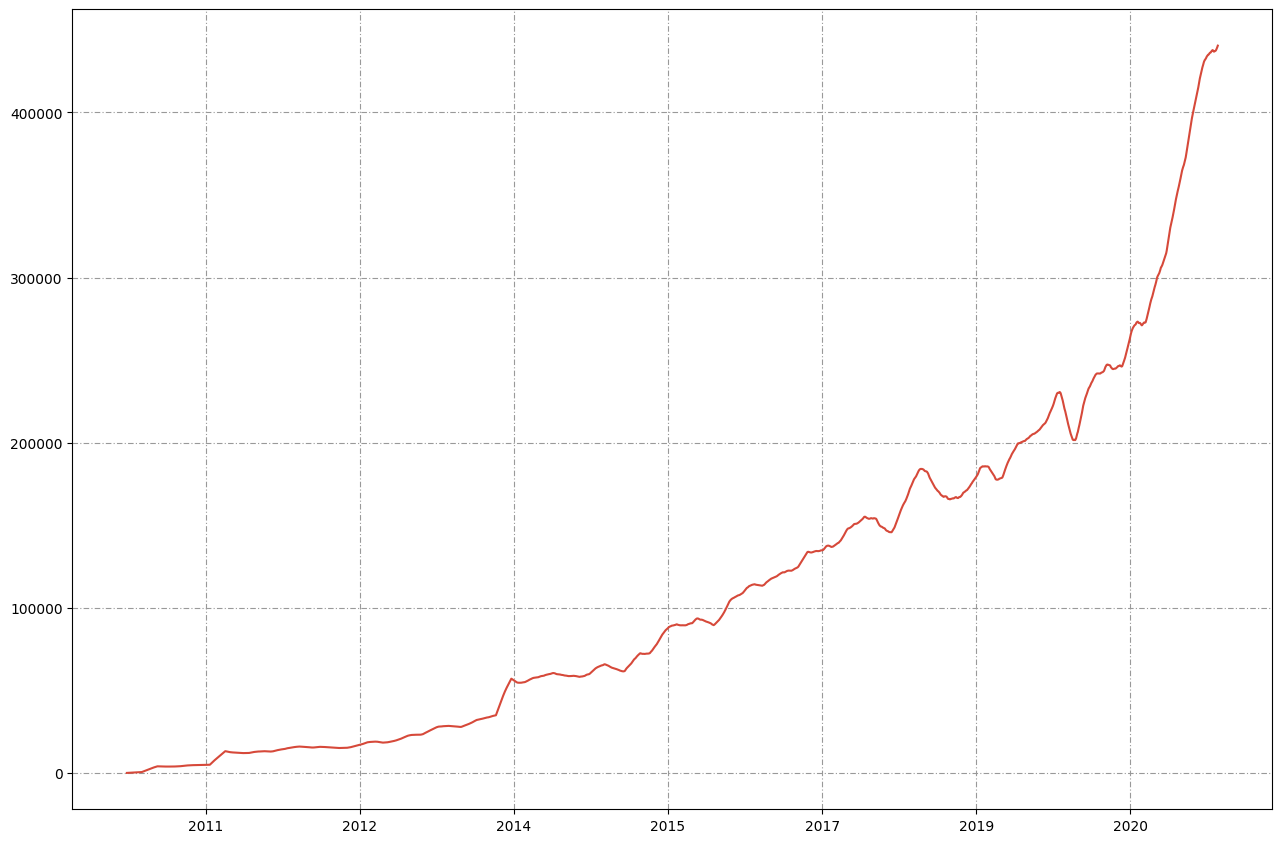

In [25]:
# Plots
fig = plt.figure(figsize=(12,8),dpi=100)
graph = fig.add_axes([0,0,1,1])
graph.xaxis.set_major_locator(plt.MaxNLocator(8))
graph.grid(True, color='0.6', dashes=(5, 2, 1, 2))

# plotPortfolio(graph, 0,1, df_rolling, '#4385e0') # Daily Value
# plotPortfolio(graph, 0,2, df_rolling, '#6cc460') # 7-day rolling avg
# plotPortfolio(graph, 0,3, df_rolling, '#c99232') # 30-day rolling avg
plotPortfolio(graph, 0,4, df_rolling, '#d6493a') # 60-day rolling avg

In [20]:
print("\n-- Overall Summary --")

firstDate = df_dailyActivity["Date"].min().strftime('%d/%m/%Y')
lastDate =  df_dailyActivity["Date"].max().strftime('%d/%m/%Y')
length_years = int(len(df_monthSum)/12)
length_months = len(df_monthSum)%12
print("You've been investing for {0} year(s) and {1} month(s), between {2} and {3}".format(length_years, length_months, firstDate, lastDate))

sum_trades = len(df_buys) + len(df_sells)
sum_buys = len(df_buys)
sum_sells = len(df_sells)
print("You made a total of {0} trades ({1} buys/{2} sells)".format(sum_trades, sum_buys, sum_sells))

sum_deposit = df_dailyActivity["Deposit"].astype(int).sum() - df_dailyActivity["Net Income"].sum()
print("You invested a total of £{0}".format(sum_deposit))

mean_buy = (df_buys["Value"].mean()*-1).round(2)
print("Your mean investment was £{}".format(mean_buy))

current_value = df_dailyActivity.loc[df_dailyActivity['Date'].idxmax()]["Value"].round(2)
increase = (current_value - sum_deposit).round(2)
increase_per = ((increase/sum_deposit)*100).round(1)
print("Your current portfolio is worth {0}, this is an increase of {1} ({2}%)".format(current_value, increase, increase_per))

print("\n-- Monthly Summary --")

maxBuy_month = df_monthSum.loc[df_monthSum['Total Bought'].idxmax()]["Date"].strftime('%m/%Y')
maxBuy_amount = df_monthSum["Total Bought"].max().round(2)
print("You spent the most in {0} (£{1})".format(maxBuy_month, maxBuy_amount))

maxSell_month = df_monthSum.loc[df_monthSum['Total Sold'].idxmax()]["Date"].strftime('%m/%Y')
maxSell_amount = df_monthSum["Total Sold"].max().round(2)
print("You sold the most in {0} (£{1})".format(maxSell_month, maxSell_amount))

maxValue_month = df_monthSum.loc[df_monthSum['Avg. Value'].idxmax()]["Date"].strftime('%m/%Y')
maxValue_amount = df_monthSum["Avg. Value"].max().round(2)
print("Your highest-value month was {0} (£{1})\n".format(maxValue_month, maxValue_amount))

print(df_monthSum)

print("\n-- Ticker Summary --")
print(df_tickerSum)


-- Overall Summary --
You've been investing for 11 year(s) and 11 month(s), between 23/01/2010 and 10/11/2021
You made a total of 201 trades (200 buys/1 sells)
You invested a total of £24860.0
Your mean investment was £124.55
Your current portfolio is worth 458758.22, this is an increase of 433898.22 (1745.4%)

-- Monthly Summary --
You spent the most in 02/2015 (£689.0)
You sold the most in 10/2021 (£50.0)
Your highest-value month was 11/2021 (£461621.37)

          Date  Total Bought  Total Sold     Avg. Value
0   2010-01-01         100.0         0.0       6.156144
1   2010-02-01           0.0         0.0       7.392753
2   2010-03-01         332.0         0.0     257.268848
3   2010-04-01           0.0         0.0     479.094012
4   2010-05-01         142.0         0.0    1811.355194
..         ...           ...         ...            ...
138 2021-07-01         346.0         0.0  408554.083485
139 2021-08-01         371.0         0.0  429285.829763
140 2021-09-01         213.0     

In [ ]:
df_dailyActivity = df_dailyActivity.round(2)
df_monthSum = df_monthSum.round(2)

df_dailyActivity.to_csv('./outputs/dailyActivity.csv', index=False)
df_closing_all.to_csv('./outputs/dailyClose.csv', index=False)
df_rolling.to_csv('./outputs/valueRolling.csv', index=False)
df_monthSum.to_csv('./outputs/monthSum.csv', index=False)
df_tickerSum.to_csv('./outputs/tickerSum.csv', index=False)